In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
This notebook demonstrates how to read data from the Toggl API and do some simple analysis. 
Written by Stefan Kussmaul, https://www.stefanonsoftware.com.
"""
import api
import matplotlib.pyplot as plt
from datetime import date, datetime

plt.rcParams['font.family'] = 'SimHei' # Microsoft YaHei

# Enter your Toggl email and password here.
TOGGL_EMAIL = r'shenmingxin2000@gmail.com'
TOGGL_PASSWORD = r'79C4666496efe567311ec8bd1f768580'

_api = api.TogglApi(TOGGL_EMAIL, TOGGL_PASSWORD)

In [53]:
# Call the `me` endpoint and get the default workspace ID.
my_data = _api.me()
WORKSPACE_ID = my_data['default_workspace_id']
print(f"Default workspace_id is {WORKSPACE_ID}.")

Default workspace_id is 1598655.


In [54]:
# Load project data.
projects = _api.project_data(WORKSPACE_ID)
print(f"Loaded data for {len(projects)} projects.")

Loaded data for 32 projects.


In [55]:
import requests
from base64 import b64encode

data = requests.get(f'https://api.track.toggl.com/api/v9/workspaces/{WORKSPACE_ID}/project_users', headers={'content-type': 'application/json', 'Authorization' : 'Basic %s' %  b64encode(b"shenmingxin2000@gmail.com:79C4666496efe567311ec8bd1f768580").decode("ascii")})
print(data.json())

[{'id': 167777461, 'project_id': 197142558, 'user_id': 2393531, 'workspace_id': 1598655, 'manager': True, 'rate': None, 'rate_last_updated': None, 'at': '2023-11-19T00:10:17+00:00', 'group_id': None, 'gid': None, 'labor_cost': None, 'labor_cost_last_updated': None}, {'id': 143057134, 'project_id': 191621884, 'user_id': 2393531, 'workspace_id': 1598655, 'manager': True, 'rate': None, 'rate_last_updated': None, 'at': '2023-04-21T21:26:10+00:00', 'group_id': None, 'gid': None, 'labor_cost': None, 'labor_cost_last_updated': None}, {'id': 138179639, 'project_id': 189050718, 'user_id': 2393531, 'workspace_id': 1598655, 'manager': True, 'rate': None, 'rate_last_updated': None, 'at': '2023-01-25T01:33:54+00:00', 'group_id': None, 'gid': None, 'labor_cost': None, 'labor_cost_last_updated': None}, {'id': 177967410, 'project_id': 202527594, 'user_id': 2393531, 'workspace_id': 1598655, 'manager': True, 'rate': None, 'rate_last_updated': None, 'at': '2024-05-07T00:43:00+00:00', 'group_id': None, 'g

In [56]:
# Calculate the sum of hours tracked.
print(f"You tracked a total of {sum(p.actual_hours for p in projects)} hours.")

# Sort projects by time spent.
projects.sort(key=lambda p: p.actual_hours, reverse=True)
print('\n'.join(f"{p.name}: {p.actual_hours} hours" for p in projects))

You tracked a total of 336 hours.
睡眠: 67 hours
生活: 46 hours
Maths Undergraduate: 34 hours
娱乐: 27 hours
AI CDT: 18 hours
记录计划: 15 hours
626 Methods for Data Science: 13 hours
PhD Application: 13 hours
Research: 13 hours
Career: 12 hours
UCL CSML: 10 hours
折腾: 9 hours
COMP0078: 8 hours
643 Statistical Theory: 7 hours
阅读写作: 7 hours
644 Statistical Modelling 2: 6 hours
Side project: 6 hours
COMP0171: 5 hours
Master Thesis: 4 hours
648 Survival Models: 3 hours
Calculus: 3 hours
COMP0085: 2 hours
COMP0086: 2 hours
COMP0089: 2 hours
Literature reading: 2 hours
SAT: 1 hours
UROP: 1 hours
304 Computer 101: 0 hours
605 Optimisation: 0 hours
COMP0082: 0 hours
DET: 0 hours
Email: 0 hours


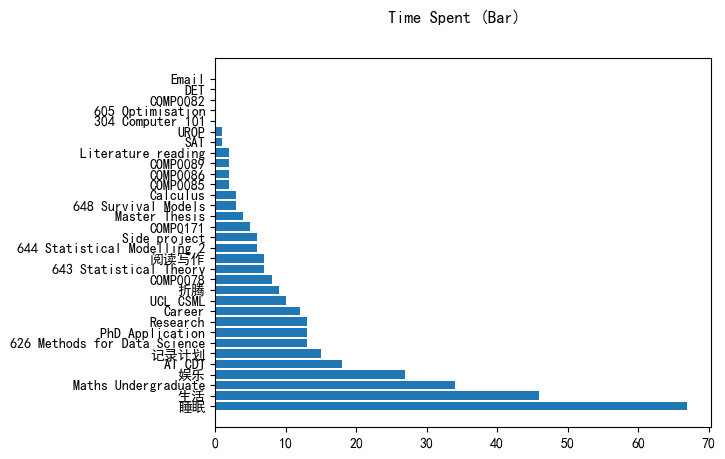

In [60]:
# Make a simple bar plot of projects by time spent.
# Note: adding a semicolon ";" at the end of the plot statement hides the annoying text that the notebook would normally print.
fig, ax = plt.subplots()
fig.suptitle('Time Spent (Bar)')
ax.barh(
    [p.name for p in projects],
    [p.actual_hours for p in projects],
);

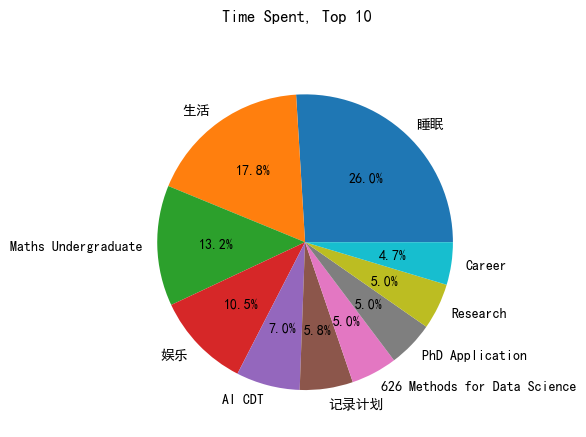

In [61]:
# Make a pie plot of the top 10 projects.
# If there are fewer than 10 projects, limit to the number of projects we have.
n = min(10, len(projects))

fig, ax = plt.subplots()
fig.suptitle(f"Time Spent, Top {n}")
ax.pie(
    [p.actual_hours for p in projects[:n]],
    labels=[p.name for p in projects[:n]],
    autopct="%1.1f%%",
);

In [62]:
# Load all tracked time entries from the past three months.
# This is the maximum amount of time that the Toggl TimeEntry API supports.
from dateutil.relativedelta import relativedelta
start_date = (datetime.now() - relativedelta(months=3)).date()
end_date = datetime.now().date()

time_entries = _api.time_entries(start_date, end_date)
print(f"Loaded {len(time_entries)} time entries between {start_date} and {end_date}.")

Loaded 66 time entries between 2024-11-13 and 2025-02-13.


In [63]:
import pandas as pd

In [ ]:
# Convert entries data into dataframe

def create_df(time_entries, projects):
    data = [entry.__dict__ for entry in time_entries]

    # 创建 DataFrame
    df = pd.DataFrame(data)

    # 优化时间列显示（如果时区信息未被自动识别）
    df['Start'] = pd.to_datetime(df['start'], utc=True)
    df['End'] = pd.to_datetime(df['stop'], utc=True)

    # 可选：将 duration 转换为时间增量（单位：秒）
    df['Duration'] = pd.to_timedelta(df['duration'], unit='s')
    # 将 projects 转换为字典映射：{project_id: project_name}
    project_id_to_name = {project.id: project.name for project in projects}

    # 使用 map 函数将 project_id 替换为 project name
    df['Project'] = df['project_id'].map(project_id_to_name)
    df.drop(columns=['project_id', 'workspace_id', 'start', 'stop'], inplace=True)
    print(df.head())
    return df

In [67]:
import statistics
from IPython.display import Markdown

def format_seconds(sec: int) -> str:
    """Returns a human-readable string describing the number of hours
    and minutes that make up the given number of seconds."""
    hours = int(sec // 3600)
    minutes = (sec - hours * 3600) // 60  
    return f'{hours} hours {minutes} minutes'
    

# Create a mapping of project ID to project name.
project_names = {p.id: p.name for p in projects}

# Generate a Markdown table with some basic statistics.
table = "| Project | Num Entries | Time Spent | Avg. Duration |\n"
table += "| --- | --- | --- | --- |\n"
for project_id, project_name in project_names.items():
    # Get a list of time entries that match `project_id`.
    project_entries = list(filter(lambda t: (t.project_id == project_id), time_entries))
    if len(project_entries) != 0:
        time_spent = sum(t.duration for t in project_entries)
        avg_duration = int(statistics.mean(t.duration for t in project_entries)) if project_entries else 0
        table += f"| {project_name} | {len(project_entries)} | {format_seconds(time_spent)} | {format_seconds(avg_duration)} |\n"

Markdown(table)

| Project | Num Entries | Time Spent | Avg. Duration |
| --- | --- | --- | --- |
| AI CDT | 20 | 18 hours 16 minutes | 0 hours 54 minutes |
| 记录计划 | 9 | 2 hours 33 minutes | 0 hours 17 minutes |
| Research | 17 | 13 hours 44 minutes | 0 hours 48 minutes |
| 折腾 | 1 | 0 hours 7 minutes | 0 hours 7 minutes |
| Side project | 8 | 6 hours 11 minutes | 0 hours 46 minutes |
| Literature reading | 1 | 0 hours 24 minutes | 0 hours 24 minutes |
| Email | 2 | 0 hours 15 minutes | 0 hours 7 minutes |


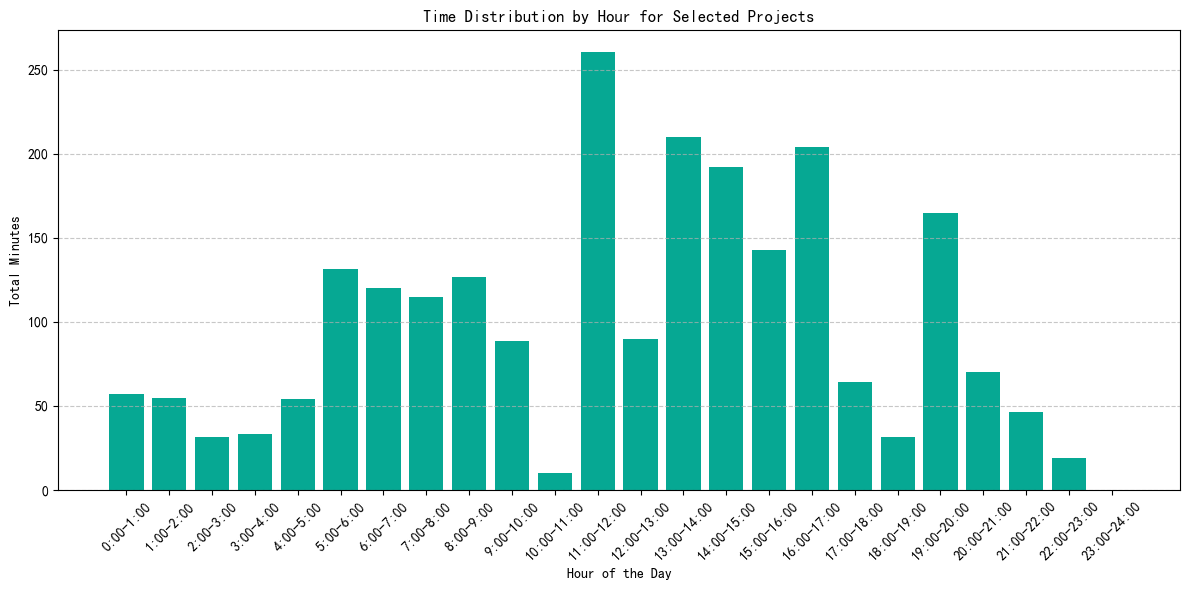

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone

# 假设 df 是之前创建的 DataFrame
# 筛选出指定的 project_name
def hourly_chart(df, filter):
    filtered_df = df.copy()
    for _, key in enumerate(filter):
        # selected_projects = ['Research', 'AI CDT', 'Literature reading', 'Side project']  # 替换为你需要的项目名称
        filtered_df = filtered_df[filtered_df[key].isin(filter[key])]

    # 初始化一个字典，用于存储每个小时的时间贡献
    hourly_distribution = {hour: 0 for hour in range(24)}

    # 遍历筛选后的数据
    for _, row in filtered_df.iterrows():
        start = row['Start']
        stop = row['End']
        duration = (stop - start).total_seconds() / 60  # 将持续时间转换为分钟

        # 按小时拆分时间贡献
        current_time = start
        while current_time < stop:
            next_hour = (current_time.replace(minute=0, second=0, microsecond=0) + pd.Timedelta(hours=1))
            segment_end = min(next_hour, stop)
            segment_duration = (segment_end - current_time).total_seconds() / 60  # 当前小时的时间贡献（分钟）
            
            # 更新对应小时的时间贡献
            hour = current_time.hour
            hourly_distribution[hour] += segment_duration
            
            # 移动到下一个时间段的起点
            current_time = segment_end

        # 将结果转换为 DataFrame 方便绘图
        hourly_df = pd.DataFrame(list(hourly_distribution.items()), columns=['hour', 'minutes'])
        hourly_df.sort_values('hour', inplace=True)

        # 绘制条状图
        plt.figure(figsize=(12, 6))
        plt.bar(hourly_df['hour'], hourly_df['minutes'], color='#06a893')
        plt.xlabel('Hour of the Day')
        plt.ylabel('Total Minutes')
        plt.title('Time Distribution by Hour for Selected Projects')
        plt.xticks(range(24), [f'{hour}:00-{hour+1}:00' for hour in range(24)], rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        return hourly_df

In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# NOTE maximum time entries for each set of detailed reports is 50

# 初始化结束时间
end = datetime.now()

# 存储每年的报告数据
reports = []

# 循环获取过去 7 年的数据
for _ in range(10):
    # 如果 end 不是 1 月 1 日，将 start 调整为当年的 1 月 1 日
    if end.month != 1 or end.day != 1:
        start = datetime(end.year, 1, 1)
    else:
        start = end - relativedelta(years=1)
    
    # 获取当前时间段的报告
    report = _api.detailed_reports(WORKSPACE_ID, start.date(), end.date()).time_entries
    reports.append((start.year, report))  # 存储年份和报告数据
    
    # 更新时间段
    end = start - relativedelta(days=1)  # 将 end 设置为上一年的最后一天

# 打印每年的报告数据
for year, report in reports:
    print(f"Year: {year}, Entries: {len(report)}")

Year: 2025, Entries: 20
Year: 2024, Entries: 50
Year: 2023, Entries: 50
Year: 2022, Entries: 50
Year: 2021, Entries: 3
Year: 2020, Entries: 9
Year: 2019, Entries: 0
Year: 2018, Entries: 0
Year: 2017, Entries: 7
Year: 2016, Entries: 0
